In [605]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [606]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
# from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA
from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitModelLoRA2, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, MyRNNCell, ImplicitRNNCellLoRA, SimpleRNN, LSTM, GRU

In [607]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [608]:
import numpy as np
import matplotlib.pyplot as plt

# Spiky region function
def spiky_function(x, scale=5, freq=[2, 23, 78, 100]):
    return scale * (np.sin(freq[0]*x) + np.sin(freq[1]*x) + np.sin(freq[2]*x) + np.sin(freq[3]*x))

# Non-spiky region function with added noise
def non_spiky_function(x, noise_mean=0, noise_std=0.25):
    return np.sin(x) + np.random.normal(noise_mean, noise_std, size=x.shape)


generate=False
if generate:
    # Parameters
    total_data_points = 10000
    num_spiky_regions = 20
    spiky_region_size = 100
    spiky_region_magnitude = 20

    # Generate data
    x_values = np.linspace(0, 100, total_data_points)
    y_values = np.zeros(total_data_points)

    # Assign spiky regions
    spiky_regions = torch.randint(0, total_data_points - spiky_region_size, (num_spiky_regions, ))
    for start_idx in spiky_regions:
        end_idx = start_idx + spiky_region_size
        x_spiky = x_values[start_idx:end_idx]
        y_values[start_idx:end_idx] = spiky_function(x_spiky)
        
    # Assign non-spiky regions
    mask = y_values == 0

    y_values[mask] = non_spiky_function(x_values[mask])
    # Plot the generated data
    plt.figure(figsize=(12, 6))
    plt.plot(y_values, label="Generated Data")
    plt.title("Generated Data with Spiky and Non-Spiky Regions")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
    np.savetxt('./kaggle/input/spiky_data.csv', y_values, delimiter=',', fmt='%.17g')

y_values = np.loadtxt('./kaggle/input/spiky_data.csv', delimiter=',')

In [609]:
easy_data = True

if easy_data:
    # Parameters
    total_data_points = 10000
    num_spiky_regions = 20
    spiky_region_size = 100
    spiky_region_magnitude = 0.25

    # Generate data
    x_values = np.linspace(0, 100, total_data_points)
    y_values = np.zeros(total_data_points)

    # Assign spiky regions
    spiky_regions = torch.randint(0, total_data_points - spiky_region_size, (num_spiky_regions, ))
    for start_idx in spiky_regions:
        end_idx = start_idx + spiky_region_size
        x_spiky = x_values[start_idx:end_idx]
        y_values[start_idx:end_idx] = spiky_function(x_spiky, spiky_region_magnitude)
        
    # Assign non-spiky regions
    mask = y_values == 0

    y_values[mask] = non_spiky_function(x_values[mask], noise_mean=0, noise_std=0.01)

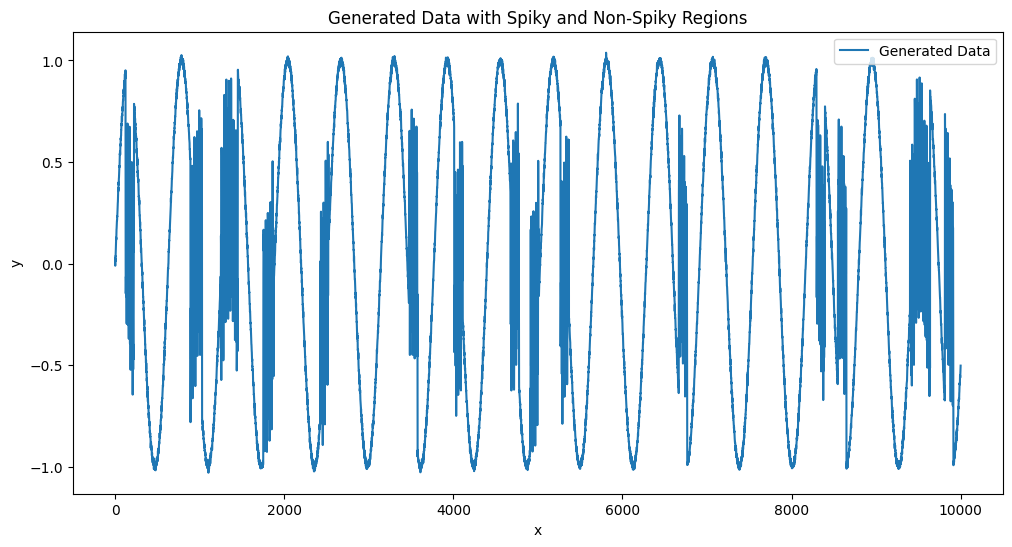

In [610]:
%matplotlib inline

# Plot the generated data
plt.figure(figsize=(12, 6))
plt.plot(y_values, label="Generated Data")
plt.title("Generated Data with Spiky and Non-Spiky Regions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Data rescaling 

In [611]:
y_values.shape 
print(y_values)
scaler = MinMaxScaler(feature_range=(-1, 1))
model=scaler.fit(y_values.reshape(-1,1))
y_values=model.transform(y_values.reshape(-1,1))
y_values=y_values.reshape(-1)
print(y_values)

[ 0.0016297  -0.01061968  0.02766134 ... -0.5352105  -0.50692271
 -0.5026001 ]
[-0.00240797 -0.01425356  0.02276555 ... -0.52155146 -0.49419617
 -0.49001606]


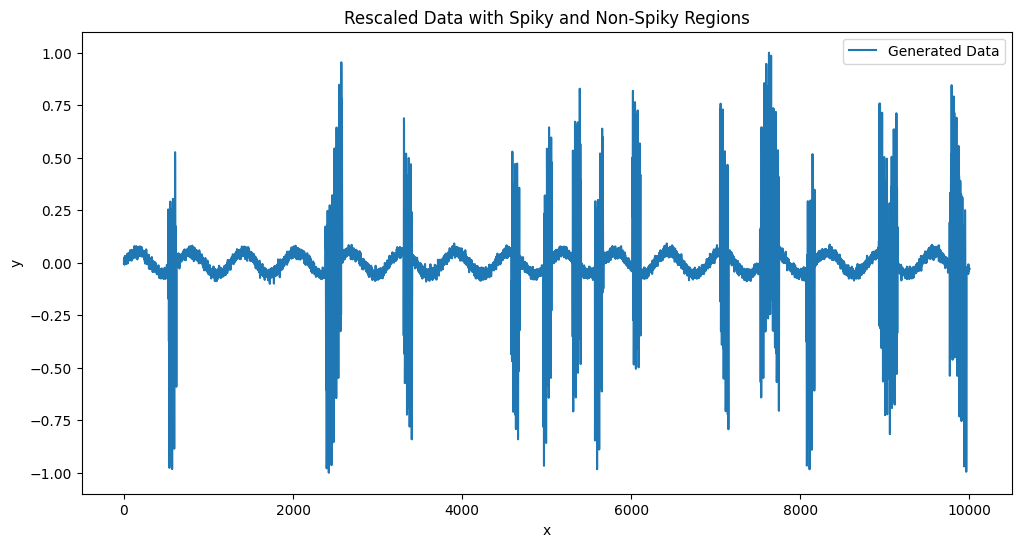

In [599]:
plt.figure(figsize=(12, 6))
plt.plot(y_values, label="Generated Data")
plt.title("Rescaled Data with Spiky and Non-Spiky Regions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Test and Train dataset

In [612]:
# function to create train, test data given stock data and sequence length
# we are predicting future so last portion of our data will be recorded as the test dataset example 50000 datapoints last 10k rakhlo future ka lia
def load_data(stock, look_back):
    # data_raw = stock.values # convert to numpy array
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    # we will take data example 0 to 60 then 1 to 61 then 2 to 62 ------ window size 
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index:index + look_back])
    #print(data[0:3])
    data = np.array(data)

    test_set_size = int(np.round(0.4*data.shape[0])) #30 percent for test
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


look_back = 60 # choose sequence length # window size
# data_ = data[fea_name].values.reshape(-1,1)
data = y_values.reshape(-1,1)
x_train, y_train, x_test, y_test = load_data(data, look_back)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (5964, 59, 1)
y_train.shape =  (5964, 1)
x_test.shape =  (3976, 59, 1)
y_test.shape =  (3976, 1)


In [613]:
from typing import Optional

class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    
def fuse_parameters(model):
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)
    
# Here we define our model as a class
class OldVersionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #.detach() is a PyTorch method that creates a new tensor that does not require gradients. 
        out = self.fc(out[:, -1, :])
        return out
    
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, hn = self.rnn(x, h0.detach()) #.detach() is a PyTorch method that creates a new tensor that does not require gradients. 
        out = self.fc(out[:, -1, :])
        return out    

class ImplicitRNN(nn.Module):
    def __init__(self, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.implicit = ImplicitRNNCell(input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)

class ImplicitRNNLoRA(nn.Module):
    def __init__(self, lora_size, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.implicit = ImplicitRNNCellLoRA(lora_size, input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)

# Define and train Model

In [614]:

def train_model(model, x_train, y_train, optimiser, loss_fn, num_epochs=200, device=torch.device('cuda')):
    hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        # print(model.par.device)
        y_train_pred = model(x_train)
        
        loss = loss_fn(y_train_pred, y_train)
        # if t % 10 == 0 and t !=0:
        #     print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    return model, hist

def plot_hist(hist):
    plt.figure()
    plt.plot(hist, label="Training loss")
    
def evaluate_model(x_train, y_train, x_test, y_test, model):
    x_test = x_test.to(device)
    y_test_pred = model(x_test)
    y_test_pred = y_test_pred.cpu().detach().numpy()
    y_test= y_test.cpu().detach().numpy()
    x_train= x_train.cpu().detach().numpy()
    x_test= x_test.cpu().detach().numpy()
    y_train= y_train.cpu().detach().numpy()
    
    from sklearn.metrics import r2_score, mean_absolute_percentage_error
    mape = mean_absolute_percentage_error(y_test_pred, y_test)
    r2 = r2_score(y_test_pred, y_test)
    # print(f'r2 (higher better):    {r2:.2f}')
    # print(f'MAPE (smaller better): {mape:.2f}') 
    return r2, mape, y_test_pred

In [615]:
input_size = x_train.shape[1]
lora_size = 1
hidden_size = 22
output_size = 1
more_state = 2

make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_lora = lambda: ImplicitModelLoRA(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_rnn = lambda: ImplicitRNN(1, hidden_size-2, hidden_size-2, output_size, f=CustomInf, no_D=False)
make_imp_rnn_lora = lambda: ImplicitRNNLoRA(lora_size, 1, hidden_size-2, hidden_size-2, output_size, f=CustomInf, no_D=False)
make_simple_rnn = lambda: SimpleRNN(1, hidden_size+1, 2, True, output_size, 'relu')

model size: 1804 parameters


r2 (higher better):    0.99 +- 0.00
MAPE (smaller better): 0.44 +- 0.36
Best r2 (higher better):    0.99 at iteration 14
Best MAPE (smaller better): 0.25 at iteration 7


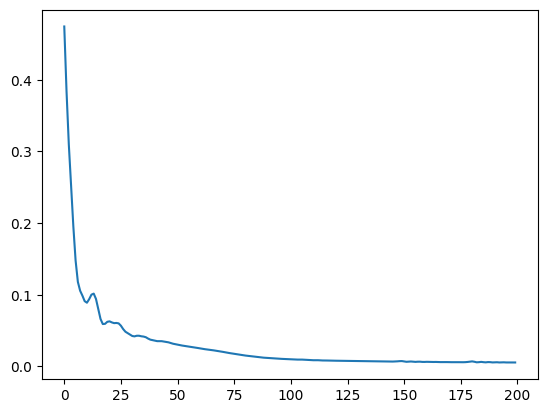

In [616]:
import torch
import torch.nn as nn


# Build model
input_dim = 1
hidden_dim = 12 #15
num_layers = 2
output_dim = 1

r2s = []
mapes = []

for i in range(20):
    # model, lr = LSTM(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, num_layers=num_layers, bias=True).to(device), 0.08 # new code 
    # model, lr = OldVersionLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device), 0.08 # old code
    # model, lr = RNN(input_dim=1, hidden_dim=21, output_dim=1, num_layers=2).to(device), 0.08    # defined by Hoang Anh
    # try RNN_implicit model
    # model, lr = make_simple_rnn().to(device), 0.05    # defined by anh Khai
    model, lr = MLP(input_size, hidden_size, output_size, nn.ReLU).to(device), 0.005
    # model, lr = make_imp_relu().to(device), 0.02
    # model, lr = make_imp_lora().to(device), 0.02
    # model, lr = make_imp_rnn().to(device), 0.004
    # model, lr = make_imp_rnn_lora().to(device), 0.008
    model.to(device)
    if i == 0:
        print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')

    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    
    model, hist = train_model(model, x_train, y_train, optimiser, loss_fn, num_epochs=200, device=device)
    if i==9:    
        plot_hist(hist)
    
    r2, mape, y_test_pred = evaluate_model(x_train, y_train, x_test, y_test, model)
    r2s.append(r2)
    mapes.append(mape)

print(f'r2 (higher better):    {np.mean(r2s):.2f} +- {np.std(r2s):.2f}')
print(f'MAPE (smaller better): {np.mean(mapes):.2f} +- {np.std(mapes):.2f}')
############# can calibrate size of RNN to compartible with imp_rnn
best_r2_index = np.argmax(r2s)
best_mape_index = np.argmin(mapes)

print(f'Best r2 (higher better):    {r2s[best_r2_index]:.2f} at iteration {best_r2_index}')
print(f'Best MAPE (smaller better): {mapes[best_mape_index]:.2f} at iteration {best_mape_index}')

# Make Predictions


In [94]:
x_test = x_test.to(device)
y_test_pred = model(x_test)
y_test_pred = y_test_pred.cpu().detach().numpy()
y_test= y_test.cpu().detach().numpy()
x_train= x_train.cpu().detach().numpy()
x_test= x_test.cpu().detach().numpy()
y_train= y_train.cpu().detach().numpy()

In [95]:
print(y_test_pred.shape, y_test.shape)
print(*zip(y_test_pred[0:5], y_test[0:5]))

(3976, 1) (3976, 1)
(array([-0.18010212], dtype=float32), array([-0.2727296], dtype=float32)) (array([-0.24785574], dtype=float32), array([-0.19969553], dtype=float32)) (array([0.10164787], dtype=float32), array([0.17293061], dtype=float32)) (array([0.50096345], dtype=float32), array([0.521818], dtype=float32)) (array([0.5420479], dtype=float32), array([0.5428779], dtype=float32))


# Accuracy score

In [96]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_pred, y_test)
r2 = r2_score(y_test_pred, y_test)
print(f'r2 (higher better):    {r2:.2f}')       # refer to https://en.wikipedia.org/wiki/Coefficient_of_determination
print(f'MAPE (smaller better): {mape:.2f}')     # refer to https://arize.com/blog-course/mean-absolute-percentage-error-mape-what-you-need-to-know/

r2 (higher better):    0.92
MAPE (smaller better): 11.03


# Inverse transform

to see how accurate our results are on line Graph

In [97]:
# Inverse transform y_test_pred and y_test
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

In [98]:
len(y_train), len(y_test)

(5964, 3976)

# Results

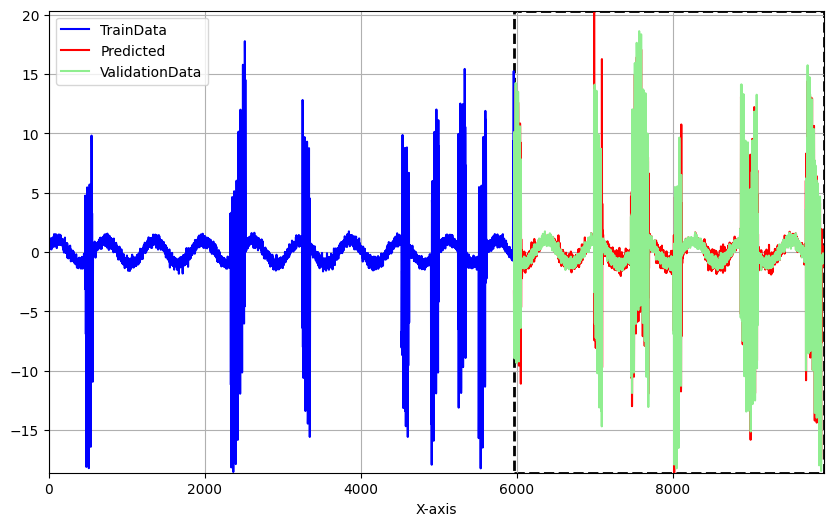

In [99]:
# %matplotlib inline
import matplotlib.patches as patches

# Assuming y_train, y_test_pred, and y_test are already defined
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot y_train with a different color
plt.plot(range(len(y_train)), y_train, label='TrainData', color='blue')  

# Plot y_test_pred and y_test with different colors
plt.plot(range(len(y_train), len(y_train) + len(y_test_pred)), y_test_pred, label='Predicted', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='ValidationData', color='lightgreen')

# Set the y-axis limits based on the minimum and maximum values of both arrays
plt.ylim(min(y_train.min(), y_test_pred.min(), y_test.min()), max(y_train.max(), y_test_pred.max(), y_test.max()))

# Set the x-axis limits
plt.xlim(0, len(y_train) + len(y_test))

# Add labels and title
plt.xlabel('X-axis')
# plt.ylabel(fea_name)

# Display the legend
plt.legend()

# Add a square around the y_t
ax = plt.gca()
rect = patches.Rectangle((len(y_train), min(y_test_pred.min(), y_test.min())), len(y_test_pred), 
                         max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min()), 
                         linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
ax.add_patch(rect)
# Show the plot
plt.grid(True)  # Add a grid if desired
plt.show()


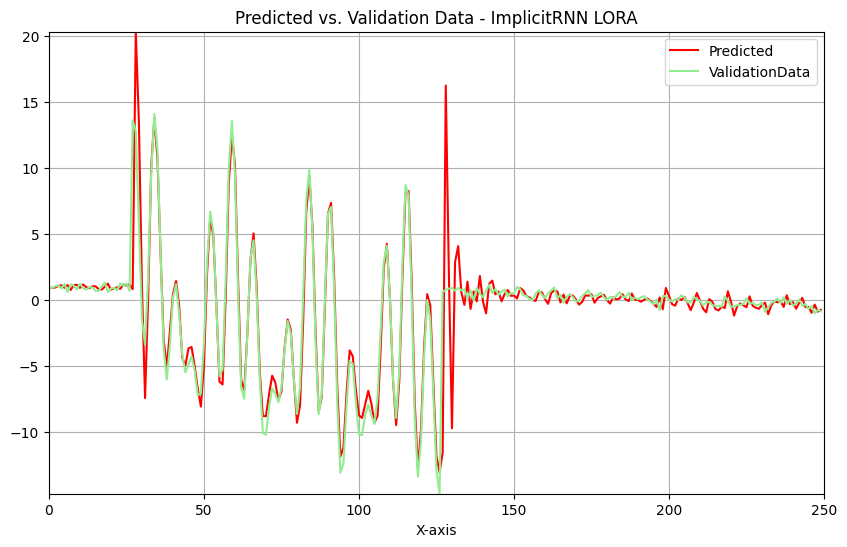

In [100]:
# %matplotlib inline
import matplotlib.patches as patches
start = 1000
end = start + 250

# Assuming y_train, y_test_pred, and y_test are already defined
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed


# Plot y_test_pred and y_test with different colors
plt.plot(range(len(y_test_pred[start:end])), y_test_pred[start:end], label='Predicted', color='red')
plt.plot(range(len(y_test[start:end])), y_test[start:end], label='ValidationData', color='lightgreen')

# Set the y-axis limits based on the minimum and maximum values of both arrays
plt.ylim(min(y_test_pred[start:end].min(), y_test[start:end].min()), max(y_test_pred[start:end].max(), y_test[start:end].max()))

# Set the x-axis limits
plt.xlim(0, len(y_test[start:end]))

# Add labels and title
plt.xlabel('X-axis')
# plt.ylabel(fea_name)

# Display the legend
plt.legend()

# # Add a square around the y_t
# ax = plt.gca()
# rect = patches.Rectangle((len(y_train), min(y_test_pred.min(), y_test.min())), len(y_test_pred), 
#                          max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min()), 
#                          linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
# ax.add_patch(rect)
# # Show the plot
plt.title("Predicted vs. Validation Data - ImplicitRNN LORA")
plt.grid(True)  # Add a grid if desired
plt.show()


- chạy nốt các thí nghiệm với model khác
- tune dataset để thấy rõ khác biệt giữ idl với edl
- hoàn thành bảng
- tiếp earthquake

only >=, <=, =
no < or > for LP problem
